# Logistic regression

## Model

Each data point is associated with values $X_1 = x_1, X_2 = x_2, \ldots, X_m = x_m \in\mathbb{R}$ for  features $X_1$, $X_2$, $\ldots$, $X_m$. It is also associated with a value $Y = y \in \{0,1\}$ for binary variable $Y$. For a given data point, we are interested in predicting the value of $Y$ given the values of $X_1$, $X_2$, $\ldots$, $X_m$.

To perform that task, we employ a model to express the probability
$$p_y(\mathbf{x}) = P(Y = y\;|\;\mathbf{X} = \mathbf{x}) = P(Y = y \; | \; X_1 = x_1, X_2 = x_2, \ldots, X_m = x_m).$$

In the case of `logistic regression`, the model defines that probability as follows.

$$p_1(\mathbf{x}) = 1/(1 + e^{-\beta(\mathbf{x})})$$

$$p_0(\mathbf{x}) = 1 - p_1(\mathbf{x}) = 1/(1 + e^{+\beta(\mathbf{x})})$$

$$\beta(\mathbf{x}) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_m x_m$$

It follows that

$$\log(p_1/p_0) = \beta(\mathbf{x}) $$

## Likelihood and A-posteriori Probability

Given an instance LR = LR(\beta('mathbf{x})) of Logistic Regression, what is the log-likelihood of a dataset (i.e., set of data points) $\mathbb{D}$?

$ \log L(D;LR) = \log P(\mathbb{D}\;|\;LR, I) = \sum _{d\in\mathbb{D}:Y=1}{\log(p_1)} + \sum _{d\in\mathbb{D}:Y=0}{\log(p_0)} = $

$= -\sum_{d:Y=1}{\log(1 + e^{-\beta(\mathbf{x}_d)})} - \sum _{d:Y=0}{\log(1 + e^{\beta(\mathbf{x_d})})}$

$= -\sum_{d}{\log(1 + e^{(1 - 2y_d)\beta(\mathbf{x}_d)})}$

With the same zero-mean Gaussian prior on the values of the beta parameters, the a-posteriori probability takes the following form.

$\log P(\mathbb{D},\ LR|\; I) = -\sum_{d}{\log(1 + e^{(1 - 2y_d)\beta(\mathbf{x}_d)})} - \lambda \sum_{i=0}^{m}\beta_i^2,\;\; \lambda > 0$

## Maximizing A-posteriory Probability

To optimize log-likelihood in terms of parameters $\beta$, we take it's derivative w.r.t. the same parameters.

$\frac{d\log L(D;LR)}{d\beta_0} = \sum_{d: Y=1}{\frac{1}{1 + e^{\beta(\mathbf{x_d})}}} - \sum_{d: Y=0}{\frac{1}{1 + e^{-\beta(\mathbf{x_d})}}}$

$\frac{d\log L(D;LR)}{d\beta_i} = \sum_{d: Y=1}{\frac{1}{1 + e^{\beta(\mathbf{x_d})}}\mathbf{x_d}(i)}  - \sum_{d: Y=0}{\frac{1}{1 + e^{-\beta(\mathbf{x_d})}}\mathbf{x_d}(i)}$


Note that $(1 + e^{\beta(\mathbf{x})})^{-1} = p_0(\mathbf{x}) = 1 - p_1(\mathbf{x})$ and $(1 + e^{-\beta(\mathbf{x})})^{-1} = p_1(\mathbf{x})$, therefore the previous formulas can be written as

$\frac{d\log L(D;LR)}{d\beta_0} = \sum_{d: Y=1}{(1 - p_1(\mathbf{x_d}))} + \sum_{d: Y=0}{(0 - p_1(\mathbf{x_d}))}
= \sum_{d}{(y - p_{1}(\mathbf{x_d}))} $

$\frac{d\log L(D;LR)}{d\beta_i} = \sum_{d: Y=1}{(1 - p_1(\mathbf{x_d}))\cdot\mathbf{x_d}(i)}  + \sum_{d: Y=0}{(0 - p_1(\mathbf{x_d}))\cdot\mathbf{x_d}(i)} = \sum_d {{(y - p_{1}(\mathbf{x_d}))} \cdot\mathbf{x_d}(i)} $

We can employ, then, gradient ascent.

For each data point $\mathbf{x}$, we update parameters $\mathbf{\beta} = [\beta_0, \beta_1, \beta_2, \ldots, \beta_m]$ as follows.

$$\mathbf{\beta} := \mathbf{\beta} + \alpha \cdot (y - p_1) [1, x_1, x_2, \ldots, x_m], \ \alpha > 0$$

To maximize the a-posteriory probability under the previously defined priors,
the updates change to 
$$\mathbf{\beta} := \mathbf{\beta} + \alpha \cdot (y - p_1) [1, x_1, x_2, \ldots, x_m] - 2\lambda\cdot \mathbf{\beta}, \ \alpha > 0$$

In [417]:
import pyspark
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt

In [420]:
%matplotlib inline

In [ ]:
sc = pyspark.SparkContext()

## Generating synthetic data 

In [578]:
def make_data(beta, N = 1000):

    m = len(beta) - 1
    x = np.column_stack((np.ones(N), -3 + 8. * np.random.rand(N, m)))
#     x = np.column_stack((np.ones(N), np.linspace(-2, 2, N)))

    logit = np.sum(x * beta, axis = 1)
    p1 = 1. / (1. + np.exp(-logit))

    y = stats.bernoulli(p1).rvs()

    data = np.column_stack((y, x))
    return data, p1

In [587]:
beta = np.array([1, -1, 0])

In [596]:
data, p1 = make_data(beta, 1000)

In [597]:
y = data[:,0]
sum(y == 0)

515

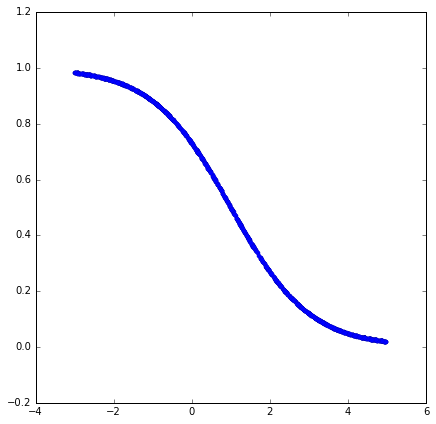

In [598]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.scatter(data[:,2], p1, lw = 0.05)

## Training

In [621]:
def point_logl(x, beta):
    """return the log-likelihood for a single data point"""
    y = x[0]
    sign = (1 if y == 0 else -1)
    return - np.log(1 + np.exp(sign * np.sum(x[1:] * beta)))

def update_data_point(x, alpha, beta):
    """return the gradient ascent update for a single data point"""
    y = x[0]
    p1 = np.sum(beta * x[1:])
    return alpha * (y - p1) * x[1:]

In [625]:
# we initialize the estimates for \beta parameters to
# ranom points in the interval (beta_min, beta_min + beta_range)
beta_min = -1.5
beta_range = 3

def logistic_regression(data, alpha = 1e-6, ell = 0.01):
    """
    return an estimate for the logistic regression parameters, along with the
    aposteriory probability of the dataset for those parameter values
    """
    dataRDD = sc.parallelize(data)
    dataRDD.persist()
    
    m = data.shape[1] - 1
    beta = beta_min + beta_range * np.random.rand(m)
    
    def app(rdd):
        """
        return the a-posteriory probability for a given rdd for the current
        beta parameter values
        """
        return rdd.map(lambda x: point_logl(x, beta)).reduce(lambda x, y: x + y) - \
            ell * np.sum(beta ** 2)
    
    du = np.inf
    apost = app(dataRDD)
    for loop in range(10) :
        u = dataRDD.map(lambda x: update_data_point(x, alpha, beta)).reduce(lambda x, y: x + y)
        beta = beta + u - ell * beta
        du = max(abs(u - ell * beta))
        apost = app(dataRDD)
    return beta, apost   

In [627]:
TRIALS = 20

results = []
print("Round #", end = " ")
for i in range(TRIALS):
    print((i+1), end = ", ")
    res = logistic_regression(data)
    results.append(res)
results = sorted(results, key = lambda x: -x[1])

Round # 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

In [628]:
# results = sorted(results, key = lambda x: -x[1])
for res in results:
    print(*res)

[-0.31991173 -1.12441453  0.01131151] -486.04053705
[ 0.79498767 -0.77870856  0.54306996] -544.757620725
[ 1.27032943 -0.43519351  0.19761428] -596.864783774
[ 0.50664543 -1.11163139 -0.67633002] -601.660595247
[-0.80359684 -0.36382204  0.42423771] -618.322904205
[-1.12938849 -1.18323583  0.67618026] -624.992761402
[ 0.66969263 -0.26270983 -0.55861011] -694.814456229
[-0.77715467 -0.11993915  0.44787435] -744.418895476
[-1.12159863  0.01011869 -0.35165771] -982.843572984
[ 0.29948806 -0.74058689  1.22555953] -1008.16830779
[ 0.17314898  0.08777572 -0.85334254] -1177.3484993
[ 0.85253573  0.31911873 -0.00540655] -1188.05161939
[ 0.49587142  0.39261414 -0.12401798] -1193.9809825
[ 0.65402179  0.23028815 -0.88749186] -1312.49206328
[ 1.08541374 -0.22664161  1.06458282] -1374.13777178
[-0.7737979   0.47804902  0.60915503] -1444.64157341
[-0.30993281  0.80822045 -0.30393083] -1759.80153268
[ 0.02112958  0.76302603 -0.64021312] -1801.293199
[-0.09892286  0.81482246  0.41752273] -1928.9240757

In [629]:
mybeta = results[0][0]
notmybeta = results[0][-1]

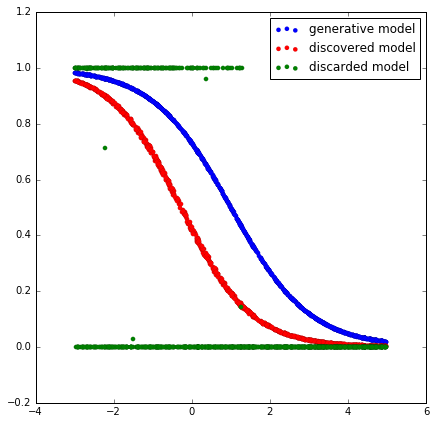

In [630]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.scatter(data[:,2], p1, lw = 0.05, c = "blue", label = "generative model")
logit = np.sum(data[:, 1:] * mybeta, axis = 1)
p = 1. / (1. + np.exp(-logit))
ax.scatter(data[:,2], p, lw = 0.05, c = "red", label = "discovered model")
logit = np.sum(data[:, 1:] * notmybeta, axis = 1)
p = 1. / (1. + np.exp(-logit))
ax.scatter(data[:,2], p, lw = 0.05, c = "green", label = "discarded model")
ax.legend()